In [7]:
###########################################################################
# Import modules
###########################################################################
from IPython.core.interactiveshell import InteractiveShell 
InteractiveShell.ast_node_interactivity = "all" 

import os
import random
from time import time

import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.morphology import watershed

import torch 
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms

In [8]:
###########################################################################
# ETL process (extract, transform and load data)
###########################################################################

## define the transforms to the train dataset
my_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5)) ## normalize the data from [0,1] to [-1,1]
])

my_transform_random = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomResizedCrop(512, interpolation=0),
    transforms.RandomRotation(180),
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5)) ## normalize the data from [0,1] to [-1,1]
])

my_transform_random_label = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomResizedCrop(512, interpolation=0),
    transforms.RandomRotation(180),
    transforms.ToTensor()
])

## define the dataset class
class train_dataset(data.Dataset):
    # root_path is the path of the type of this cell, i.e. 'DIC-C2DH-HeLa'
    def __init__(self, root_path):
        self.root_path = root_path
    def __getitem__(self, index):
        if self.root_path == 'DIC-C2DH-HeLa':
            sequence = '01'
            # some ground truth are not right, ignore them
            if index in [28,36,64,71,72,74,79,80,81,82]:
                index = 83
            if index >= 84:
                sequence = '02'
                index-=84
                # some ground truth are not right, ignore them
                if index in [0,1,15,17,24,33,42,52,55,56,57,58,59,60,62,64,69,70,72,73,74,75,76,77,79,80,83]:
                    index = 82
            img = cv2.imread(f'{self.root_path}/{sequence}/t{index:03}.tif', 0)
            img = cv2.equalizeHist(img)
            seed_num = np.random.randint(2147483647)
            random.seed(seed_num)
            img = my_transform_random(img)
            gt_mask = cv2.imread(f'{self.root_path}/{sequence}_generated_masks/mask{index:03}.tif', 0)
            random.seed(seed_num)
            gt_mask = my_transform_random_label(gt_mask.astype(np.uint8)).squeeze() 
            gt_marker = cv2.imread(f'{self.root_path}/{sequence}_generated_markers/marker{index:03}.tif', 0)
            random.seed(seed_num)
            gt_marker = my_transform_random_label(gt_marker.astype(np.uint8)).squeeze()
            weight_map = np.load(f'{self.root_path}/{sequence}_weight_map/weight_map{index:03}.npy')
            random.seed(seed_num)
            weight_map = my_transform_random_label(weight_map.astype(np.float32)).squeeze()
            return img, gt_mask, gt_marker, weight_map
        else:
            print(f'Root_path: \'{self.root_path}\' doesn\'t exist')
    def __len__(self):
        ## hard code
        if self.root_path == 'DIC-C2DH-HeLa':
            return 84*2


## Initialize the dataset and dataloader of 'DIC-C2DH-HeLa'
dic_train_dataset = train_dataset('DIC-C2DH-HeLa')
dic_train_loader = data.DataLoader(dic_train_dataset, batch_size = 4)

        

torch.Size([4, 1, 512, 512])

torch.Size([4, 512, 512])

torch.Size([4, 512, 512])

torch.Size([4, 512, 512])

array([0., 1.], dtype=float32)

array([0., 1.], dtype=float32)

array([ 0.        ,  0.39455032,  0.39455035, ..., 10.403793  ,
       10.415604  , 10.424698  ], dtype=float32)

<Figure size 1080x1080 with 0 Axes>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


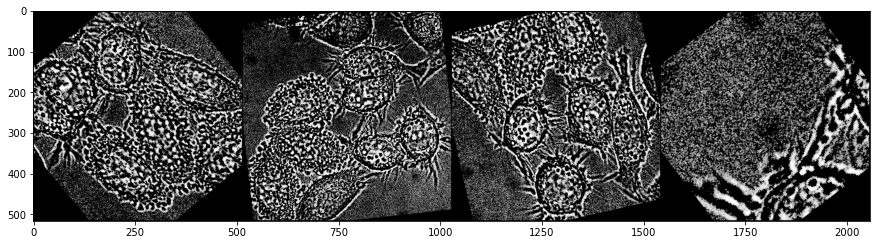

<Figure size 1080x1080 with 0 Axes>

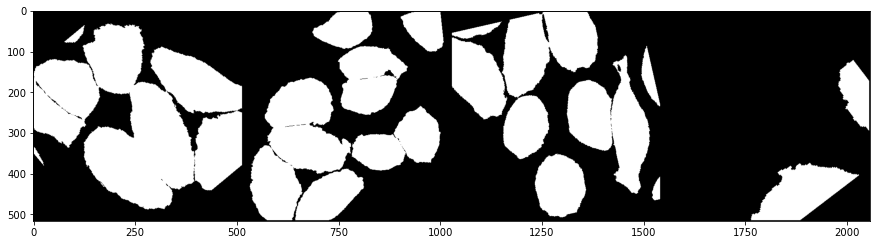

<Figure size 1080x1080 with 0 Axes>

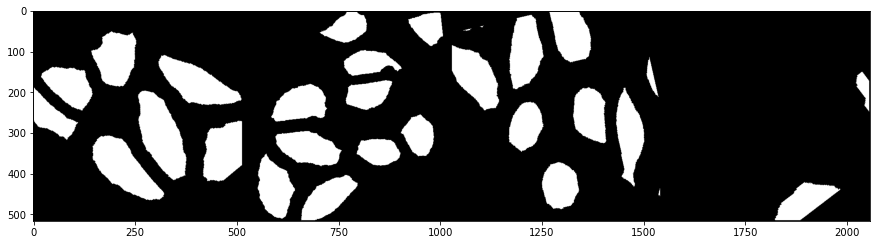

<Figure size 1080x1080 with 0 Axes>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


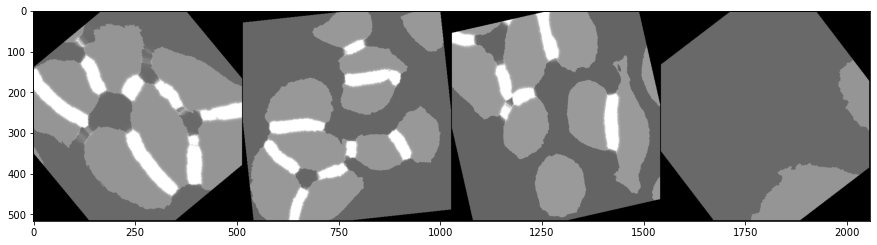

In [9]:
###########################################################################
# explore the data(testing)
###########################################################################

my_iter = iter(dic_train_loader)
sample = next(my_iter)
imgs, masks, markers, weight_maps = sample

imgs.shape
masks.shape
markers.shape
weight_maps.float().shape
np.unique(masks)
np.unique(markers)
np.unique(weight_maps)
grid = torchvision.utils.make_grid(imgs, nrow = 4)
plt.figure(figsize = (15,15))
plt.imshow(np.transpose(grid, (1,2,0)))
plt.show()

grid = torchvision.utils.make_grid(masks.unsqueeze(1), nrow = 4)
plt.figure(figsize = (15,15))
plt.imshow(np.transpose(grid, (1,2,0)))
plt.show()

grid = torchvision.utils.make_grid(markers.unsqueeze(1), nrow = 4)
plt.figure(figsize = (15,15))
plt.imshow(np.transpose(grid, (1,2,0)))
plt.show()

grid = torchvision.utils.make_grid(weight_maps.unsqueeze(1), nrow = 4)
plt.figure(figsize = (15,15))
plt.imshow(np.transpose(grid, (1,2,0)))
plt.show()



In [10]:
###########################################################################
# DIC-C2DH-HeLa CNN class
###########################################################################
class dic_cnn(nn.Module):
    def __init__(self):
        super(dic_cnn, self).__init__()
        # down
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1, )
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)

        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)

        self.conv5 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)

        self.conv7 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.conv8 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)

        self.conv9 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1)
        self.conv10 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)

        # up
        self.conv11 = nn.Conv2d(in_channels=768, out_channels=256, kernel_size=3, padding=1)
        self.conv12 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)

        self.conv13 = nn.Conv2d(in_channels=384, out_channels=128, kernel_size=3, padding=1)
        self.conv14 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)

        self.conv15 = nn.Conv2d(in_channels=192, out_channels=64, kernel_size=3, padding=1)
        self.conv16 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)

        self.conv17 = nn.Conv2d(in_channels=96, out_channels=32, kernel_size=3, padding=1)
        self.conv18 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)

        # final
        self.conv19 = nn.Conv2d(in_channels=32, out_channels=2, kernel_size=1, padding = 0)

    def forward(self, images):
        res_conv1 = F.relu(self.conv1(images))
        res_conv2 = F.relu(self.conv2(res_conv1))
        res_maxpool1 = F.max_pool2d(res_conv2, kernel_size = 2, stride = 2) 

        res_conv3 = F.relu(self.conv3(res_maxpool1))
        res_conv4 = F.relu(self.conv4(res_conv3))
        res_maxpool2 = F.max_pool2d(res_conv4, kernel_size = 2, stride = 2)

        res_conv5 = F.relu(self.conv5(res_maxpool2))
        res_conv6 = F.relu(self.conv6(res_conv5))
        res_maxpool3 = F.max_pool2d(res_conv6, kernel_size = 2, stride = 2)

        res_conv7 = F.relu(self.conv7(res_maxpool3))
        res_conv8 = F.relu(self.conv8(res_conv7))
        res_maxpool4 = F.max_pool2d(res_conv8, kernel_size = 2, stride = 2)

        res_conv9 = F.relu(self.conv9(res_maxpool4))
        res_conv10 = F.relu(self.conv10(res_conv9))
        
        res_up1 = nn.Upsample(scale_factor=2, mode = 'bilinear')(res_conv10)
        res_cat1 = torch.cat((res_up1, res_conv8), dim=1)
        res_conv11 = F.relu(self.conv11(res_cat1))
        res_conv12 = F.relu(self.conv12(res_conv11))

        res_up2 = nn.Upsample(scale_factor=2, mode='bilinear')(res_conv12)
        res_cat2 = torch.cat((res_up2, res_conv6), dim=1)
        res_conv13 = F.relu(self.conv13(res_cat2))
        res_conv14 = F.relu(self.conv14(res_conv13))

        res_up3 = nn.Upsample(scale_factor=2, mode='bilinear')(res_conv14)
        res_cat3 = torch.cat((res_up3, res_conv4), dim=1)
        res_conv15 = F.relu(self.conv15(res_cat3))
        res_conv16 = F.relu(self.conv16(res_conv15))

        res_up4 = nn.Upsample(scale_factor=2, mode='bilinear')(res_conv16)
        res_cat4 = torch.cat((res_up4, res_conv2), dim=1)
        res_conv17 = F.relu(self.conv17(res_cat4))
        res_conv18 = F.relu(self.conv18(res_conv17))

        output = self.conv19(res_conv18)
        #output = F.softmax(output, dim=1)

        return output




In [20]:
###########################################################################
# Training process, using GPU
# if you don't have a GPU which has a huage memory, then it doesn't work
###########################################################################
mask_net = dic_cnn().to('cuda')
marker_net = dic_cnn().to('cuda')

optimizer_marker = torch.optim.Adam(marker_net.parameters(), lr = 0.0003)
optimizer_mask = torch.optim.Adam(mask_net.parameters(), lr = 0.0003)
start_time = time()

# define my own weighed cross entropy, because pytorh doesn't support pixel-wise weight
def weighted_cross_entropy(preds, targets, weight_maps):
    logp = F.log_softmax(preds)
    logp = logp.gather(1, targets.view(4, 1, 512, 512))
    weighted_logp = (logp*weight_maps.unsqueeze(1)).view(4, -1)
    weighted_loss = weighted_logp.sum(1)/weight_maps.view(4, -1).sum(1)
    weighted_loss = -1. * weighted_loss.mean()
    return weighted_loss

# 100 epoch
for epoch in range(100):
    # change the learning rate when traiining
    if epoch == 71:
        for param in optimizer_mask.param_groups:
            param['lr'] = 0.00003
        for param in optimizer_marker.param_groups:
            param['lr'] = 0.000003
    for index, batch in enumerate(dic_train_loader, 0):
        ## unpack data
        imgs, masks, markers, weight_maps = batch
        masks = masks.long()
        markers = markers.long()
        weight_maps = weight_maps.float()
        imgs = imgs.to('cuda')
        masks = masks.to('cuda')
        markers = markers.to('cuda')
        weight_maps = weight_maps.to('cuda')
        
        
        #zero the gradient
        optimizer_marker.zero_grad()
        optimizer_mask.zero_grad()
        
        pred_markers = marker_net(imgs)
        loss_marker = weighted_cross_entropy(pred_markers, markers, weight_maps)
        loss_marker.backward()
        optimizer_marker.step()

        pred_masks = mask_net(imgs)
        #loss_mask = weighted_cross_entropy(pred_masks, masks, weight_maps)
        loss_mask = F.cross_entropy(pred_masks, masks)
        loss_mask.backward()
        optimizer_mask.step()

    print(f'Epoch {epoch} is finished, running time {time() - start_time}s')
    print('loss mask', loss_mask.item())
    print('loss marker', loss_marker.item())     
    start_time = time()
# save the two model
torch.save(mask_net, 'mask_net.pkl')
torch.save(marker_net, 'marker_net.pkl')

Epoch 0 is finished, running time 32.92753529548645s
loss mask 0.5530538558959961
loss marker 0.3883665204048157
Epoch 1 is finished, running time 34.18079471588135s
loss mask 0.6065406203269958
loss marker 0.33911168575286865
Epoch 2 is finished, running time 34.57610201835632s
loss mask 0.5223994255065918
loss marker 0.3670523762702942
Epoch 3 is finished, running time 33.50497341156006s
loss mask 0.505442202091217
loss marker 0.355071485042572
Epoch 4 is finished, running time 32.84990477561951s
loss mask 0.5167286396026611
loss marker 0.3738349676132202
Epoch 5 is finished, running time 33.067665338516235s
loss mask 0.5127010345458984
loss marker 0.36647066473960876


KeyboardInterrupt: 